# CAPTCHA Recognition Pipeline with Segmentation

This notebook integrates the character segmentation approach from `segmentation.py` with a CNN-based character recognition model.

## 1. Environment Setup

In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path
from sklearn.cluster import KMeans

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Character set
CHARS = "0123456789abcdefghijklmnopqrstuvwxyz"
VOCAB_SIZE = len(CHARS)
ch2id = {ch: i for i, ch in enumerate(CHARS)}
id2ch = {i: ch for ch, i in ch2id.items()}

print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Characters: {CHARS}")

device: cuda
Vocabulary size: 36
Characters: 0123456789abcdefghijklmnopqrstuvwxyz


## 2. Import Segmentation Functions

Import the segmentation functions directly from `segmentation.py`.

In [2]:
# Import segmentation functions from segmentation.py
from segmentation import get_dominant_clusters

def segment_characters(image_path, min_pixels=3, top_components=5):
    """
    Segment CAPTCHA characters using adaptive KMeans thresholding.
    Returns a list of character images and their labels.
    This uses the same logic as segment_and_save_characters from segmentation.py
    but returns the data instead of saving to files.
    """
    filename = Path(image_path).stem
    chars_part = filename.split("-")[0]
    n_clusters = len(chars_part) + 1  # +1 for noise cluster

    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Cannot read image: {image_path}")

    threshold = 250
    max_threshold = 250
    step = 10
    valid_bounding_boxes = []

    # Try increasing threshold until enough clusters found
    while threshold <= max_threshold:
        clustered_masks, mask_foreground = get_dominant_clusters(image, n_clusters, threshold)
        if clustered_masks is None:
            threshold += step
            continue

        bounding_boxes = []
        for idx, mask in enumerate(clustered_masks):
            ys, xs = np.where(mask > 0)
            if len(xs) == 0:
                continue
            x_min, x_max = np.min(xs), np.max(xs)
            y_min, y_max = np.min(ys), np.max(ys)
            w, h = x_max - x_min + 1, y_max - y_min + 1
            bounding_boxes.append((x_min, y_min, w, h, mask))

        if len(bounding_boxes) >= n_clusters:
            valid_bounding_boxes = bounding_boxes
            break
        threshold += step

    if not valid_bounding_boxes:
        print(f"[WARNING] Failed to segment {image_path}")
        return [], []

    cluster_pixel_counts = []
    cleaned_clusters = []
    cluster_x_positions = []  # store leftmost pixel x position of largest component

    # Clean clusters (keep top N largest connected parts, filter by distance)
    for i, (x, y, w, h, mask) in enumerate(valid_bounding_boxes):
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

        if num_labels > 1:
            areas = stats[1:, cv2.CC_STAT_AREA]
            sorted_idx = np.argsort(areas)[::-1]  # largest → smallest

            keep_mask = np.zeros_like(mask)
            count_kept = 0
            first_center = None
            distance_threshold = 25  # tune for your CAPTCHA size

            for idx2 in sorted_idx:
                if count_kept >= top_components:
                    break
                area = areas[idx2]
                if area < min_pixels:
                    continue

                label = idx2 + 1
                cx, cy = centroids[label]

                if first_center is None:
                    # Always keep the first (largest) component
                    first_center = (cx, cy)
                    keep_mask[labels == label] = 255
                    count_kept += 1
                else:
                    # Compute Euclidean distance to the first component
                    dist = np.sqrt((cx - first_center[0]) ** 2 + (cy - first_center[1]) ** 2)
                    if dist < distance_threshold:
                        keep_mask[labels == label] = 255
                        count_kept += 1

            cleaned_mask = keep_mask
        else:
            cleaned_mask = mask.copy()

        # record x position of largest connected component
        ys, xs = np.where(cleaned_mask > 0)
        if len(xs) > 0:
            x_leftmost = np.min(xs)
        else:
            x_leftmost = 99999  # fallback in case mask empty

        pixel_count = np.sum(cleaned_mask > 0)
        cluster_pixel_counts.append(pixel_count)
        cleaned_clusters.append((x, y, w, h, cleaned_mask))
        cluster_x_positions.append(x_leftmost)

    # Identify cluster with fewest pixels (noise)
    min_idx = int(np.argmin(cluster_pixel_counts))

    # Sort by leftmost pixel (x position of biggest component)
    sorted_indices = np.argsort(cluster_x_positions)

    # Extract character images (excluding the noise cluster)
    char_images = []
    char_labels = []

    kept_idx = 0  # index among kept clusters (left-to-right, skipping noise)
    for i in sorted_indices:
        if i == min_idx:  # Skip noise cluster
            continue

        x, y, w, h, cleaned_mask = cleaned_clusters[i]
        roi = image[y:y + h, x:x + w]
        mask_roi = cleaned_mask[y:y + h, x:x + w]
        char_img = np.full_like(roi, 255)  # White background
        char_img[mask_roi == 255] = roi[mask_roi == 255]

        # Crop tightly to foreground
        gray = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
        ys_fg, xs_fg = np.where(gray < 250)  # find non-white pixels
        if len(xs_fg) > 0 and len(ys_fg) > 0:
            x_min_fg, x_max_fg = np.min(xs_fg), np.max(xs_fg)
            y_min_fg, y_max_fg = np.min(ys_fg), np.max(ys_fg)
            char_img = char_img[y_min_fg:y_max_fg + 1, x_min_fg:x_max_fg + 1]

        char_images.append(char_img)

        # Determine label based on kept index (align with GT positions)
        if kept_idx < len(chars_part):
            char_labels.append(chars_part[kept_idx])
        else:
            char_labels.append('')  # out of range safeguard
        kept_idx += 1

    return char_images, char_labels

## 3. Character Dataset

Dataset class that segments CAPTCHAs and provides individual character images for training.

In [3]:
class SegmentedCharDataset(Dataset):
    def __init__(self, img_paths, transform=None, target_size=(32, 32)):
        """
        Args:
            img_paths: List of CAPTCHA image paths
            transform: Optional transform to be applied on characters
            target_size: Target size for character images (H, W)
        """
        self.img_paths = img_paths
        self.transform = transform
        self.target_size = target_size
        
        # Pre-segment all images and build character dataset
        self.characters = []  # List of (char_image, label)
        self._build_dataset()
    
    def _build_dataset(self):
        print("Segmenting CAPTCHA images...")
        for img_path in tqdm(self.img_paths):
            try:
                gt_text = Path(img_path).stem.split('-')[0]
                char_images, _seg_labels = segment_characters(img_path)

                if len(char_images) == 0:
                    continue

                # Align using ground truth (trusted) and left-to-right order from segmentation
                n = min(len(char_images), len(gt_text))
                if n < len(gt_text) or n < len(char_images):
                    print(f"[INFO] Mismatch kept={len(char_images)} vs GT={len(gt_text)} for {Path(img_path).name}; using first {n} aligned pairs")

                for k in range(n):
                    ch = gt_text[k].lower()
                    if ch in ch2id:
                        self.characters.append((char_images[k], ch))
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue
        
        print(f"Total characters extracted: {len(self.characters)}")
    
    def __len__(self):
        return len(self.characters)
    
    def __getitem__(self, idx):
        char_img, label = self.characters[idx]
        
        # Preprocess character image
        char_img = self._preprocess_char(char_img)
        
        # Convert to tensor
        char_img = torch.from_numpy(char_img).float() / 255.0
        
        # Ensure 3 channels
        if char_img.dim() == 2:
            char_img = char_img.unsqueeze(0).repeat(3, 1, 1)
        elif char_img.shape[0] == 1:
            char_img = char_img.repeat(3, 1, 1)

        if self.transform:
            char_img = self.transform(char_img)
                    
        label_id = ch2id[label]
        
        return char_img, label_id, label
    
    def _preprocess_char(self, char_img):
        """
        Preprocess a single character image:
        - Convert to grayscale
        - Resize to target size
        - Maintain aspect ratio with padding
        """
        # Convert to grayscale if needed
        if len(char_img.shape) == 3:
            char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
        
        h, w = char_img.shape
        target_h, target_w = self.target_size
        
        # Check for invalid dimensions
        if h <= 0 or w <= 0:
            # Return blank canvas if image is empty
            return np.ones((target_h, target_w), dtype=np.uint8) * 255
        
        # Calculate scaling to fit within target size
        scale = min(target_h / h, target_w / w)
        new_h, new_w = int(h * scale), int(w * scale)
        
        # Ensure minimum size of 1x1
        new_h = max(1, new_h)
        new_w = max(1, new_w)
        
        # Resize
        char_img = cv2.resize(char_img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        
        # Create white canvas and center the character
        canvas = np.ones((target_h, target_w), dtype=np.uint8) * 255
        y_offset = (target_h - new_h) // 2
        x_offset = (target_w - new_w) // 2
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_img
        
        return canvas

## 4. Load and Prepare Data

In [4]:
# Data directories
TRAIN_ROOT = "processed/train"
TEST_ROOT = "processed/test"

# Get image files
train_img_files = [
    os.path.join(TRAIN_ROOT, f)
    for f in os.listdir(TRAIN_ROOT)
    if f.lower().endswith(".png")
]

test_img_files = [
    os.path.join(TEST_ROOT, f)
    for f in os.listdir(TEST_ROOT)
    if f.lower().endswith(".png")
]

print(f"Train CAPTCHA images: {len(train_img_files)}")
print(f"Test CAPTCHA images: {len(test_img_files)}")

Train CAPTCHA images: 8010
Test CAPTCHA images: 2000


In [5]:
# Create datasets (use full data) and add augmentations
train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL first
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))], p=0.2),
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# For eval: just normalize
test_transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

print("\nCreating training dataset (full set)...")
train_dataset = SegmentedCharDataset(train_img_files, transform=train_transform, target_size=(32, 32))

print("\nCreating test dataset (full set)...")
test_dataset = SegmentedCharDataset(test_img_files, transform=test_transform, target_size=(32, 32))


Creating training dataset (full set)...
Segmenting CAPTCHA images...


  0%|          | 1/8010 [00:04<10:28:26,  4.71s/it]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
  0%|          | 4/8010 [00:04<2:03:36,  1.08it/s] d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
  0%|        

[WARNING] Failed to segment processed/train\eh57-0.png


 40%|███▉      | 3201/8010 [03:33<05:11, 15.46it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
 40%|███▉      | 3203/8010 [03:34<05:18, 15.09it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\D\Minicond

[WARNING] Failed to segment processed/train\ggxxb1-0.png


 46%|████▌     | 3650/8010 [04:01<04:40, 15.54it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
 46%|████▌     | 3652/8010 [04:01<04:50, 15.03it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
d:\D\Minicond

[WARNING] Failed to segment processed/train\ovanqq-0.png


 69%|██████▉   | 5541/8010 [06:15<03:57, 10.41it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
 69%|██████▉   | 5543/8010 [06:15<03:33, 11.54it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
 69%|██████▉ 

[WARNING] Failed to segment processed/train\viqn2wc-0.png


 88%|████████▊ | 7018/8010 [07:53<01:07, 14.71it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
 88%|████████▊ | 7020/8010 [07:53<01:04, 15.43it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
 88%|████████▊ | 7022/8010 [07:53<01:04, 15.43it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variabl

[WARNING] Failed to segment processed/train\w7in-0.png


d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
 89%|████████▉ | 7162/8010 [08:02<00:48, 17.56it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
 89%|████████▉ | 7164/8010 [08:02<00:49, 17.07it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
 90%|████████

[WARNING] Failed to segment processed/train\yve9-0.png


 96%|█████████▋| 7728/8010 [08:45<00:31,  8.85it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
 97%|█████████▋| 7730/8010 [08:45<00:27, 10.08it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
 97%|█████████▋| 7732/8010 [08:45<00:29,  9.35it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variabl

Total characters extracted: 47976

Creating test dataset (full set)...
Segmenting CAPTCHA images...


  0%|          | 0/2000 [00:00<?, ?it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
  0%|          | 2/2000 [00:00<02:56, 11.33it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
  0%|          | 5/2000 [00

[WARNING] Failed to segment processed/test\jg00cgpr-0.png


d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
 54%|█████▍    | 1075/2000 [01:17<01:00, 15.26it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
 54%|█████▍    | 1077/2000 [01:17<01:09, 13.29it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
 54%|█████▍  

[WARNING] Failed to segment processed/test\nle3tm-0.png


 66%|██████▋   | 1326/2000 [01:32<00:41, 16.20it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
 67%|██████▋   | 1331/2000 [01:33<00:56, 11.77it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
 67%|██████▋   | 1333/2000 [01:33<00:52, 12.60it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variabl

Total characters extracted: 11996


## 5. Visualize Segmented Characters

C:\Users\Jerry Jian\AppData\Local\Temp\ipykernel_34952\3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


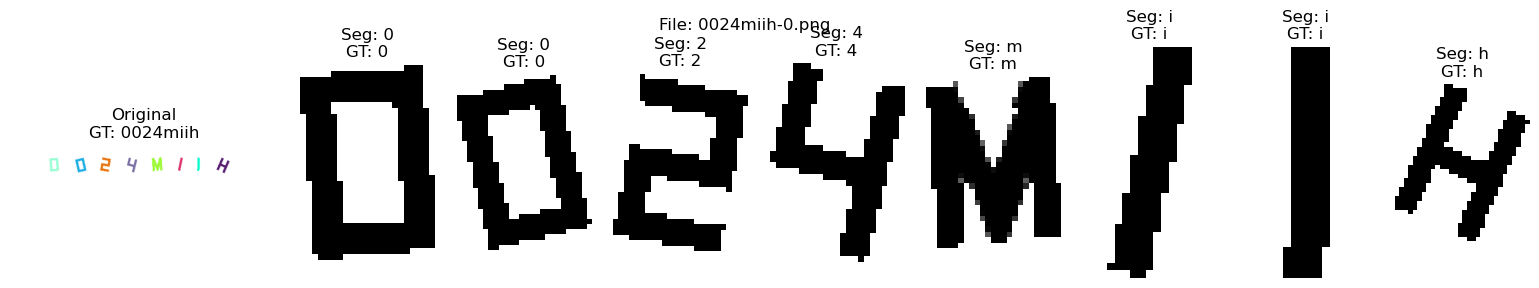

d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Jerry Jian\AppData\Local\Temp\ipykernel_34952\3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


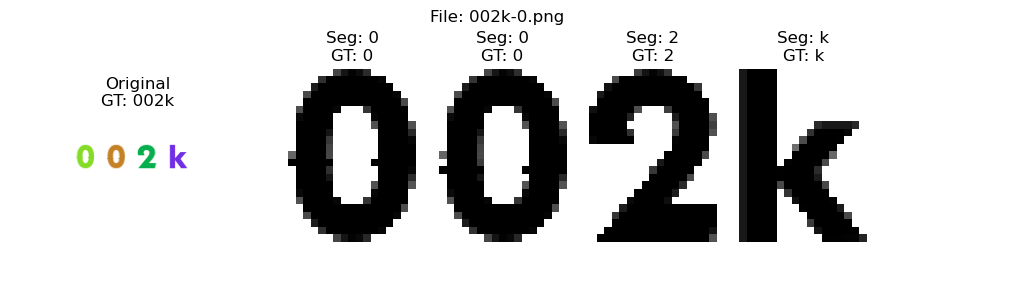

C:\Users\Jerry Jian\AppData\Local\Temp\ipykernel_34952\3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


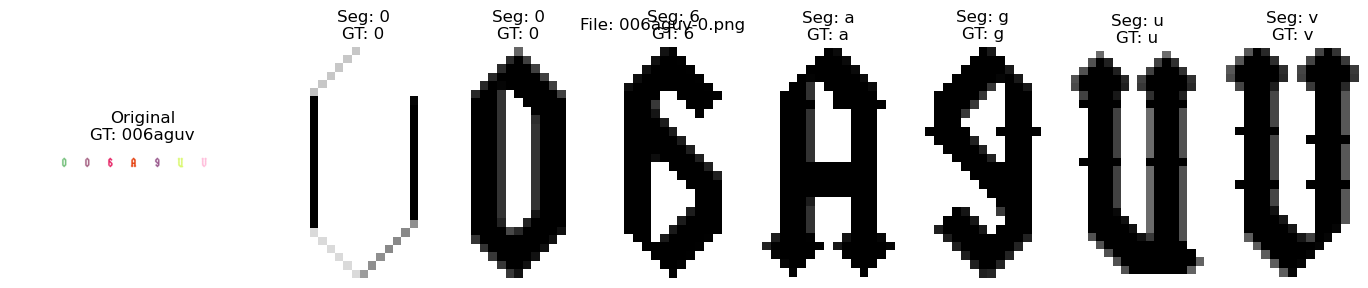

d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Jerry Jian\AppData\Local\Temp\ipykernel_34952\3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


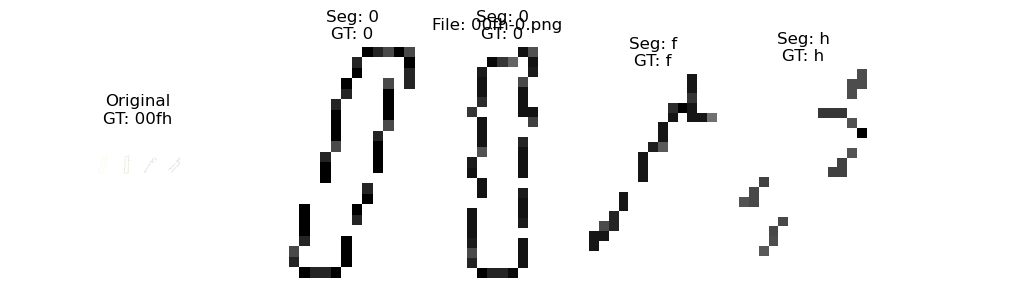

C:\Users\Jerry Jian\AppData\Local\Temp\ipykernel_34952\3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


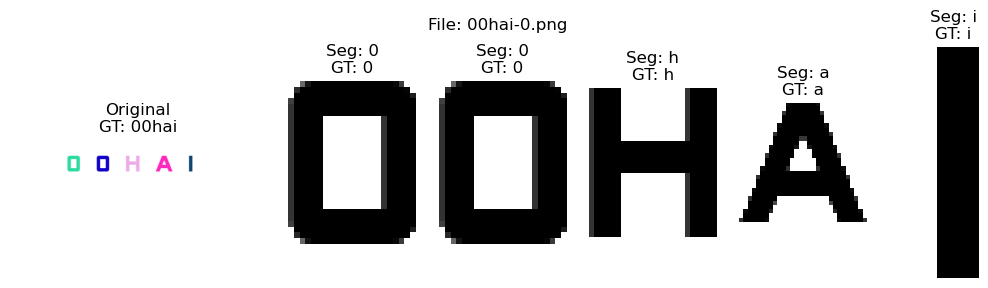

C:\Users\Jerry Jian\AppData\Local\Temp\ipykernel_34952\3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


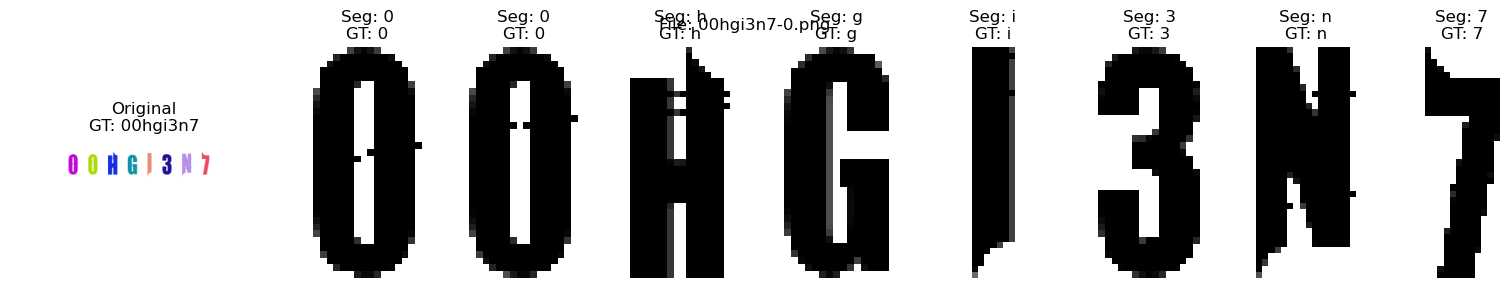

In [6]:
# Visualize original CAPTCHA alongside segmented characters for debugging
from matplotlib.gridspec import GridSpec

n_samples = 6  # how many CAPTCHAs to visualize
samples = train_img_files[:n_samples]

for img_path in samples:
    # Load original
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"[WARN] Could not read {img_path}")
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Ground truth from filename
    gt_text = Path(img_path).stem.split('-')[0]

    # Segment characters using current pipeline
    char_images, char_labels = segment_characters(img_path)

    # Prepare layout: original on the left, characters on the right
    max_chars = max(len(char_images), len(gt_text)) if len(gt_text) > 0 else len(char_images)
    max_chars = max(5, max_chars)  # keep a minimum width for readability

    fig = plt.figure(figsize=(2 + max_chars * 2.2, 3))
    gs = GridSpec(1, max_chars + 1, width_ratios=[2] + [1] * max_chars, wspace=0.15)

    # Original image
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(img_rgb)
    ax0.set_title(f"Original\nGT: {gt_text}")
    ax0.axis('off')

    # Segmented characters
    for j in range(max_chars):
        ax = fig.add_subplot(gs[0, j + 1])
        if j < len(char_images):
            ch_img = char_images[j]
            # robust grayscale for display
            if ch_img is None or ch_img.size == 0:
                ax.axis('off')
                continue
            if len(ch_img.shape) == 3:
                show_img = cv2.cvtColor(ch_img, cv2.COLOR_BGR2GRAY)
            else:
                show_img = ch_img

            # predicted label from segmentation alignment (label list) if available
            seg_label = char_labels[j] if j < len(char_labels) else '?'
            # expected char at this position (from GT) if available
            gt_char = gt_text[j] if j < len(gt_text) else ' '
            title = f"Seg: {seg_label}\nGT: {gt_char}"

            ax.imshow(show_img, cmap='gray')
            ax.set_title(title)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle(f"File: {Path(img_path).name}")
    plt.tight_layout()
    plt.show()

## 6. Character Recognition Model

CNN-based model for recognizing individual characters.

In [7]:
class CharRecognitionCNNv2(nn.Module):
    def __init__(self, num_classes=VOCAB_SIZE, dropout=0.3):
        super().__init__()
        self.features = nn.Sequential(
            # 32x32 -> 16x16
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # 16x16 -> 8x8
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # 8x8 -> 4x4
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


# Initialize model
model = CharRecognitionCNNv2(num_classes=VOCAB_SIZE).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

CharRecognitionCNNv2(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, paddi

## 7. Create DataLoaders

In [8]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True  # Drop last incomplete batch to avoid BatchNorm issues
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
    # No drop_last for test - we use model.eval() which disables BatchNorm training mode
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1499
Test batches: 375


## 8. Training Setup

In [ ]:
# Training hyperparameters
NUM_EPOCHS = 20
BASE_LR = 3e-3
MAX_LR = 1e-2
WEIGHT_DECAY = 1e-4

# Loss and optimizer (label smoothing helps robustness)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)

# OneCycleLR for fast convergence with higher LR
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=100.0,
)

## 9. Training Loop

In [10]:
def train_epoch(model, loader, criterion, optimizer, device, scheduler=None, max_grad_norm=1.0):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for imgs, labels, _ in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping for stability
        if max_grad_norm is not None and max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        # Scheduler step per batch (OneCycle)
        if scheduler is not None:
            scheduler.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'acc': 100. * correct / total
        })
    
    return running_loss / len(loader), 100. * correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels, _ in tqdm(loader, desc="Evaluating"):
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

best_acc = 0.0

# Main training loop
for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scheduler=scheduler)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    # Print summary
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_char_recognition_model.pth')
        print(f"✓ New best model saved! Accuracy: {best_acc:.2f}%")

print(f"\nTraining complete! Best accuracy: {best_acc:.2f}%")


Epoch 1/120


Evaluating: 100%|██████████| 375/375 [00:03<00:00, 117.78it/s]



Train Loss: 3.2235, Train Acc: 14.74%
Test Loss: 2.7242, Test Acc: 35.50%
✓ New best model saved! Accuracy: 35.50%

Epoch 2/120


Evaluating: 100%|██████████| 375/375 [00:02<00:00, 127.98it/s]



Train Loss: 2.6841, Train Acc: 36.42%
Test Loss: 2.3289, Test Acc: 51.09%
✓ New best model saved! Accuracy: 51.09%

Epoch 3/120


Evaluating: 100%|██████████| 375/375 [00:02<00:00, 129.36it/s]



Train Loss: 2.4797, Train Acc: 44.90%
Test Loss: 2.1975, Test Acc: 55.33%
✓ New best model saved! Accuracy: 55.33%

Epoch 4/120


Evaluating: 100%|██████████| 375/375 [00:02<00:00, 127.70it/s]



Train Loss: 2.3666, Train Acc: 49.49%
Test Loss: 2.1536, Test Acc: 57.55%
✓ New best model saved! Accuracy: 57.55%

Epoch 5/120


Evaluating: 100%|██████████| 375/375 [00:02<00:00, 126.21it/s]



Train Loss: 2.3056, Train Acc: 52.14%
Test Loss: 2.1574, Test Acc: 57.73%
✓ New best model saved! Accuracy: 57.73%

Epoch 6/120


Evaluating: 100%|██████████| 375/375 [00:02<00:00, 126.32it/s]



Train Loss: 2.2509, Train Acc: 54.24%
Test Loss: 2.0447, Test Acc: 61.99%
✓ New best model saved! Accuracy: 61.99%

Epoch 7/120


Evaluating: 100%|██████████| 375/375 [00:02<00:00, 128.46it/s]



Train Loss: 2.2208, Train Acc: 55.59%
Test Loss: 2.0231, Test Acc: 62.02%
✓ New best model saved! Accuracy: 62.02%

Epoch 8/120


Evaluating: 100%|██████████| 375/375 [00:02<00:00, 129.11it/s]



Train Loss: 2.1999, Train Acc: 56.23%
Test Loss: 2.0044, Test Acc: 62.68%
✓ New best model saved! Accuracy: 62.68%

Epoch 9/120


Evaluating: 100%|██████████| 375/375 [00:02<00:00, 128.63it/s]



Train Loss: 2.1834, Train Acc: 56.83%
Test Loss: 2.0039, Test Acc: 63.16%
✓ New best model saved! Accuracy: 63.16%

Epoch 10/120


Evaluating: 100%|██████████| 375/375 [00:02<00:00, 127.62it/s]



Train Loss: 2.1717, Train Acc: 57.49%
Test Loss: 2.0281, Test Acc: 61.94%

Epoch 11/120


Evaluating: 100%|██████████| 375/375 [00:03<00:00, 124.76it/s]



Train Loss: 2.1612, Train Acc: 57.61%
Test Loss: 1.9780, Test Acc: 63.97%
✓ New best model saved! Accuracy: 63.97%

Epoch 12/120


Evaluating: 100%|██████████| 375/375 [00:03<00:00, 119.82it/s]



Train Loss: 2.1593, Train Acc: 57.81%
Test Loss: 2.0144, Test Acc: 62.43%

Epoch 13/120


Evaluating: 100%|██████████| 375/375 [00:02<00:00, 125.29it/s]



Train Loss: 2.1613, Train Acc: 57.82%
Test Loss: 1.9827, Test Acc: 64.14%
✓ New best model saved! Accuracy: 64.14%

Epoch 14/120


Evaluating: 100%|██████████| 375/375 [00:02<00:00, 128.82it/s]



Train Loss: 2.1622, Train Acc: 58.12%
Test Loss: 2.0207, Test Acc: 61.97%

Epoch 15/120


Evaluating: 100%|██████████| 375/375 [00:03<00:00, 120.50it/s]



Train Loss: 2.1657, Train Acc: 57.79%
Test Loss: 1.9766, Test Acc: 64.43%
✓ New best model saved! Accuracy: 64.43%

Epoch 16/120


Evaluating: 100%|██████████| 375/375 [00:02<00:00, 136.52it/s]



Train Loss: 2.1656, Train Acc: 58.05%
Test Loss: 1.9812, Test Acc: 63.99%

Epoch 17/120


Evaluating: 100%|██████████| 375/375 [00:02<00:00, 132.22it/s]



Train Loss: 2.1655, Train Acc: 58.25%
Test Loss: 2.0188, Test Acc: 62.40%

Epoch 18/120


Evaluating: 100%|██████████| 375/375 [00:03<00:00, 122.76it/s]



Train Loss: 2.1706, Train Acc: 58.11%
Test Loss: 1.9892, Test Acc: 63.62%

Epoch 19/120


Training:  95%|█████████▌| 1427/1499 [01:04<00:02, 24.24it/s, loss=2.16, acc=58.1]

## 10. Visualize Training History

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['test_loss'], label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 11. Full CAPTCHA Recognition

Combine segmentation + recognition to decode complete CAPTCHAs.

In [ ]:
def recognize_captcha(model, image_path, device, target_size=(32, 32)):
    """
    Recognize a full CAPTCHA by:
    1. Segmenting characters
    2. Recognizing each character with the CNN model
    3. Combining predictions
    """
    model.eval()
    
    # Segment characters
    char_images, _ = segment_characters(image_path)
    
    if not char_images:
        return "", []
    
    predictions = []
    confidences = []
    
    with torch.no_grad():
        for char_img in char_images:
            # Preprocess
            if len(char_img.shape) == 3:
                char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
            
            h, w = char_img.shape
            target_h, target_w = target_size
            
            # Check for invalid dimensions
            if h <= 0 or w <= 0:
                continue  # Skip invalid images
            
            scale = min(target_h / h, target_w / w)
            new_h, new_w = int(h * scale), int(w * scale)
            
            # Ensure minimum size of 1x1
            new_h = max(1, new_h)
            new_w = max(1, new_w)
            
            char_img = cv2.resize(char_img, (new_w, new_h))
            
            canvas = np.ones((target_h, target_w), dtype=np.uint8) * 255
            y_offset = (target_h - new_h) // 2
            x_offset = (target_w - new_w) // 2
            canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_img
            
            # Convert to tensor
            char_tensor = torch.from_numpy(canvas).float() / 255.0
            char_tensor = char_tensor.unsqueeze(0).repeat(3, 1, 1)  # 3 channels
            char_tensor = char_tensor.unsqueeze(0).to(device)  # Add batch dimension
            
            # Predict
            output = model(char_tensor)
            probs = F.softmax(output, dim=1)
            confidence, predicted = probs.max(1)
            
            pred_char = id2ch[predicted.item()]
            predictions.append(pred_char)
            confidences.append(confidence.item())
    
    result = ''.join(predictions)
    return result, confidences


def visualize_captcha_prediction(image_path, model, device):
    """
    Visualize CAPTCHA recognition result
    """
    # Get ground truth
    filename = Path(image_path).stem
    gt_text = filename.split('-')[0]
    
    # Predict
    pred_text, confidences = recognize_captcha(model, image_path, device)
    
    # Load and display image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 4))
    plt.imshow(img_rgb)
    plt.title(f"Ground Truth: {gt_text}\nPrediction: {pred_text}\nConfidence: {np.mean(confidences):.3f}")
    plt.axis('off')
    plt.show()
    
    return gt_text, pred_text

## 12. Test on Sample CAPTCHAs

In [ ]:
# Load best model
model.load_state_dict(torch.load('best_char_recognition_model.pth'))
model.eval()

# Test on a few samples
test_samples = test_img_files[:5]

correct = 0
total = len(test_samples)

for img_path in test_samples:
    gt, pred = visualize_captcha_prediction(img_path, model, device)
    if gt == pred:
        correct += 1
        print(f"✓ Correct!\n")
    else:
        print(f"✗ Wrong. GT: {gt}, Pred: {pred}\n")

print(f"\nAccuracy: {correct}/{total} = {100*correct/total:.2f}%")

## 13. Full Test Set Evaluation

In [ ]:
def evaluate_full_captchas(model, img_paths, device):
    """
    Evaluate on full CAPTCHA images
    """
    model.eval()
    
    total = 0
    correct = 0
    char_total = 0
    char_correct = 0
    
    for img_path in tqdm(img_paths, desc="Evaluating CAPTCHAs"):
        try:
            filename = Path(img_path).stem
            gt_text = filename.split('-')[0].lower()
            
            pred_text, _ = recognize_captcha(model, img_path, device)
            pred_text = pred_text.lower()
            
            total += 1
            if gt_text == pred_text:
                correct += 1
            
            # Character-level accuracy
            for gt_ch, pred_ch in zip(gt_text, pred_text):
                char_total += 1
                if gt_ch == pred_ch:
                    char_correct += 1
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    seq_acc = 100 * correct / total if total > 0 else 0
    char_acc = 100 * char_correct / char_total if char_total > 0 else 0
    
    print(f"\nResults on {total} CAPTCHAs:")
    print(f"Sequence Accuracy: {seq_acc:.2f}% ({correct}/{total})")
    print(f"Character Accuracy: {char_acc:.2f}% ({char_correct}/{char_total})")
    
    return seq_acc, char_acc


# Evaluate on test set
test_seq_acc, test_char_acc = evaluate_full_captchas(model, test_img_files, device)

## 14. Summary and Next Steps

This notebook demonstrates:
1. ✓ Character segmentation using KMeans clustering
2. ✓ Individual character recognition using CNN
3. ✓ Full CAPTCHA recognition by combining segmentation + recognition

### Potential Improvements:
- Fine-tune segmentation parameters (threshold, min_pixels, top_components)
- Data augmentation for character recognition
- Handle overlapping characters better
- Ensemble methods or more sophisticated architectures
- Character-level sequence modeling (e.g., with context)